In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import pandas as pd
import scipy as sp
import matplotlib.mlab as mlab
import matplotlib.artist as artist
from pathlib import Path
import tkinter as tk
from tkinter import filedialog
import itertools

Select the folder where the Master Sheet I share with you.

In [6]:
askdirectory = filedialog.askdirectory() # show an "Open" dialog box and select the folder
path = Path(askdirectory)
data = pd.read_csv(path/('MasterSheet.csv'), encoding='utf-8') #read the Mster Sheet
data

,Date,Investigator,CH,[Tubulin] $(\mu M)$,[DCX] $(n M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues,DCX Type
0,2020-07-03,Sofia,13,12.0,0.0,3.959000,4.024000,0.983847,0.901208,4.066000,0.083833,48.500994,False,None
1,2020-07-03,Sofia,13,12.0,0.0,7.490000,7.880333,0.950467,0.146708,7.918000,0.167667,47.224652,False,None
2,2020-07-03,Sofia,13,12.0,0.0,3.210000,3.521000,0.911673,0.230542,3.424000,0.251500,13.614314,False,None
3,2020-07-03,Sofia,13,12.0,0.0,12.840000,14.335500,0.895679,0.817375,12.947000,1.089833,11.879798,False,None
4,2020-07-03,Sofia,13,12.0,0.0,3.424000,3.940167,0.868999,0.649708,3.210000,0.251500,12.763419,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3348,2020-09-14,Sofia,21,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,None
3349,2020-09-14,Sofia,21,6.0,0.0,2.478833,6.510000,0.380773,1.176000,2.461000,0.112000,21.973176,False,None
3350,2020-09-14,Sofia,21,6.0,0.0,1.070000,2.814000,0.380242,7.465500,1.230500,0.021000,58.595238,False,None
3351,2020-09-14,Sofia,21,6.0,0.0,0.668750,2.268000,0.294863,1.417500,0.682125,0.052500,12.992857,False,None


These are the names  in my data frame, since I'll use them over and over agian I'd rather just declare them.

In [10]:
tubulin = '[Tubulin] ' r'$(\mu M)$'
tub = 'tub'

DCXconc = '[DCX] ' r'$(n M)$'
DCX = 'DCX'
Type = 'DCX Type'

Concentration = 'Concentration ' r'$(\mu M)$'
Length = 'Length ' r'$(\mu m)$'
Lifetime = 'Lifetime ' r'$(min)$'
GrowthRate = 'Growth Rate ' r'$(\mu m / min)$'
TimeToNucleate = 'Time to Nucleate ' r'$(min)$'
ShrinkageLength = 'Shrink Length ' r'$(\mu m)$'
ShrinkageLifetime = 'Shrink Lifetime ' r'$(min)$'
ShrinkageRate = 'Shrink Rate ' r'$(\mu m / min)$'

parameters = [GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate]

# Fitting Data #

First declare the functions you are going to fit to. Here x is the variable and the other inputs are the distribution's parameters.

In [2]:
def gaussian(x, mu, sig):
    return (np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) )/(sig*np.sqrt(2*np.pi))

def exponential(x, scale):
    return ((np.exp(-x/scale) )/(scale))

def gamma(x, shape, scale):
    return (np.power(x,shape-1)*np.exp(-x/ scale))/(sp.special.gamma(shape) * np.power(scale,shape))


Then I make a function to extract a particular set of data and make a histogram. When matplotlib.pyplot makes a histogram, it saves the info on the bins used and the value of each bin.

In [3]:
def make_hist(data, parameter, tubconc, dcxtype, dcxconc): #Dataframe, what paramenter I'm plotting (e.g. GrowthRate), tubulin concentration, which dcx mutant, DCX concentration.
    
    selectdata = data[(data[tubulin]==tubconc)&(data[Type]==dcxtype)&(data[DCXconc]==dcxconc)] #this is specific to how my dataframe is organized, it just filters the data I'm interested in
    
    if parameter == GrowthRate : #The Growthrate histogram ranges from 0 to 1.5 while the other go up to 30
        maxbin = 1.5
        binsize = 0.05
    else:
        maxbin = 30
        binsize = 1
        
    n, bins, patches = plt.hist(selectdata[parameter], bins=np.arange(0, maxbin + binsize, binsize), density=True); #extracting the histogrm info n is the value of a bin, patches is image info that we don't need
    plt.clf() #This is so the image of the histogram doesn't appear, we don't need it right now
       
    return n, bins 

Next is the 'Master' fitting function where I only have to give it a dataframe with all my data (the Master Sheet) and the parameter I want to plot (e.g GrowthRate). Inside the function I loop for every tubulin concentration, dcx mutant and DCX concentration. Then it uses the previous function to get the histogram info. With this info it fits a curve  with optimize. The optimize function outputs the fitting coefficients and the variance matrix. From the matrix you can get the error after doing some simple math. Finally I make a dataframe that contains the coefficients and error for each condition.

In [8]:
def equation_fit(data, parameter):
    
    if (parameter ==  GrowthRate) | (parameter == ShrinkageRate) : #Choose an equation given a paramenter to fit
        equation = gaussian
    elif parameter == TimeToNucleate :
        equation = exponential
    elif parameter == Lifetime :
        equation = gamma
        
    results = pd.DataFrame(columns=[] , index=[]) #Declare an empty dataframe where we'll later put the results in.
    
    for tubconc in data[tubulin].unique(): #Lopping over all of my conditions
        for dcxtype in data[Type].unique():
            for dcxconc in data[DCXconc].unique():
                
                n, bins =  make_hist(data, parameter, tubconc, dcxtype, dcxconc) #Make one histogram per condition      
                
                if np.isnan(np.sum(n)) == True: #If the condition doesn't exist, skip the loop (eg. DCX Type = None, [DCX] = 50nM)
                    continue

                if equation == gamma : #THe optimize function starts with a set of paramenters and iterates to minimize the error.
                    #The default starting parameter is 1, but the gamma function needs something other than the defualt to work.
                    coeff, var_matrix = sp.optimize.curve_fit(equation,bins[:-1],n,[2,1])
                else :
                    coeff, var_matrix = sp.optimize.curve_fit(equation,bins[:-1],n) #Give optimize the function of interest, and the info we got from the histogram

                variance = np.diagonal(var_matrix) #This is the math you have to do to extract the error from the output matrix
                SE = np.sqrt(variance) #SE for Standard Error

            #======Making a data frame========
                results0 = pd.DataFrame(columns=[] , index=[]) #Declare a dataframe to put this loop's coefficients
                for k in np.arange(0,len(coeff)):
                    header = [np.array([parameter]),np.array(['Coefficient '+ str(k)])]
                    r0 = pd.DataFrame([coeff[k],SE[k]], index=(['Value','SE']),columns= header)
                    results0 = pd.concat([results0, r0], axis=1, sort=False)

                results0[tubulin] = tubconc #Adding the concentration info to thecoefficients we just saved
                results0[Type] = dcxtype
                results0[DCXconc] = dcxconc

                results = pd.concat([results, results0], sort=False) #Concatenate to the big result dataframe

    return results

Then just run the function and violà done. This is all you have to do to get the coeffients, which are also the means for the exponential and gaussian, but for but for Lifetime there are a couple of more steps you have to do to on the gamma coefficients get the mean and mean error. I haven't included them right now to keep thing simple but if you're interested just ask :)

In [11]:
GrowthRateFit = equation_fit(data, GrowthRate);
TimeToNucleateFit = equation_fit(data, TimeToNucleate);
LifetimeFit = equation_fit(data, Lifetime);
ShrinkageRateFit = equation_fit(data, ShrinkageRate);

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in power
  


<Figure size 432x288 with 0 Axes>

Concatenate the results from above

In [15]:
ResultFit = pd.concat([GrowthRateFit, TimeToNucleateFit,LifetimeFit,ShrinkageRateFit], axis=1, sort=False)
ResultFit = ResultFit.loc[:,~ResultFit.columns.duplicated()]

To plot the histogram with the fitted fuctions I use the following:

In [17]:
def plot_hist(data, tubconc, dcxtype, dcxconc) :
    
    selectdata = data[(data[tubulin]==tubconc)&(data[Type]==dcxtype)&(data[DCXconc]==dcxconc)] #again select data from Master Sheet
    fig, ax = plt.subplots(2,2,figsize=(15,15)) #declare figure
    
    n = len(selectdata.dropna().index) #gets the how many microtubules you analyzed per histogram
    
    c=0
    for i in np.arange(len(ax)):
        for j in np.arange(len(ax)):
            parameter = parameters[c]

            if parameter == GrowthRate : #same steps to make a histogram
                maxbin = 1.5
                binsize = 0.025

            else:
                maxbin = 30
                binsize = 0.5

            ax[i][j].hist(selectdata[parameter], bins=np.arange(0, maxbin + binsize, binsize), density=True);
            ax[i][j].set_title(parameter)
            ax[1][1].set_xlim(0,maxbin)
            
            c += 1
    
    selectcoeff = ResultFit[ResultFit[tubulin]==tubconc] #filter datafram for one [Tub]
    
    x = np.arange(0, 1.5 + 0.025, 0.025)
    # keep filtering the dataframe to obtain a specific coefficient
    mu = selectcoeff[(selectcoeff[Type] == dcxtype)&(selectcoeff[DCXconc] == dcxconc)][parameters[0]]['Coefficient 0'].loc['Value'] 
    sig = selectcoeff[(selectcoeff[Type] == dcxtype)&(selectcoeff[DCXconc] == dcxconc)][parameters[0]]['Coefficient 1'].loc['Value']
    ax[0][0].plot(x, gaussian(x, mu, sig)); #plot a curve with the equation and its coefficients you just got. Grwoth rate
    
    x = np.arange(0, 30 + 0.5, 0.5)
    scale = selectcoeff[(selectcoeff[Type] == dcxtype)&(selectcoeff[DCXconc] == dcxconc)][parameters[1]]['Coefficient 0'].loc['Value']
    ax[0][1].plot(x, exponential(x, scale)); #same for nucleation
    
    shape = selectcoeff[(selectcoeff[Type] == dcxtype)&(selectcoeff[DCXconc] == dcxconc)][parameters[2]]['Coefficient 0'].loc['Value']
    scale = selectcoeff[(selectcoeff[Type] == dcxtype)&(selectcoeff[DCXconc] == dcxconc)][parameters[2]]['Coefficient 1'].loc['Value']
    ax[1][0].plot(x, gamma(x, shape, scale));#lifetime
            
    mu = selectcoeff[(selectcoeff[Type] == dcxtype)&(selectcoeff[DCXconc] == dcxconc)][parameters[3]]['Coefficient 0'].loc['Value']
    sig = selectcoeff[(selectcoeff[Type] == dcxtype)&(selectcoeff[DCXconc] == dcxconc)][parameters[3]]['Coefficient 1'].loc['Value']
    ax[1][1].plot(x, gaussian(x, mu, sig)); #shrikage rate
    
    return n

222

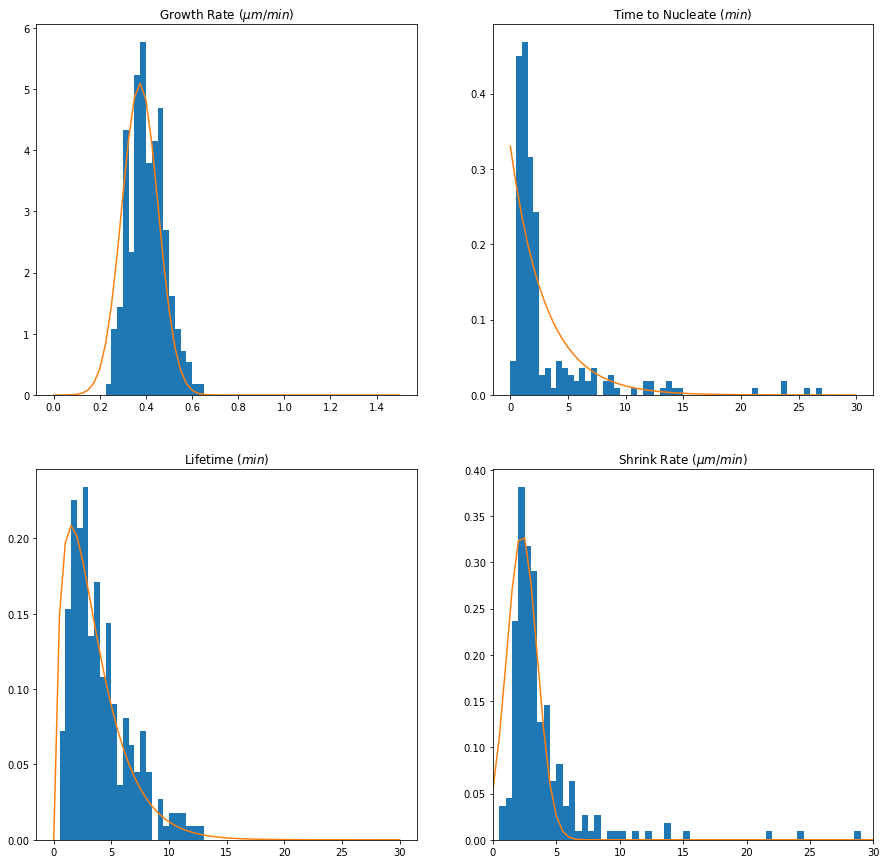

In [18]:
plot_hist(data, 6, 'P191R', 35)

I haven't bothered to make these pretty or to show the coefficients and SE's, but it's all in the Results dataframe :)

|